# Import các thư viện cần thiết

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


# I. Tiền xử lý

## 1. Đọc datasets đã được làm sạch

In [336]:
df = pd.read_csv("./data/marketing_campaign_cleaned.csv")
df.head()

,ID,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Z_CostContact,Z_Revenue,Response,Age,Age Group,Kids,Total Purchases,Spent,Family Size
0,5524,Graduation,Single,58138.0,2012-09-04,58,635,88,546,172,...,False,3,11,True,64,51-65,0,25,1617,1
1,2174,Graduation,Single,46344.0,2014-03-08,38,11,1,6,2,...,False,3,11,False,67,66+,2,6,27,3
2,4141,Graduation,In Relationship,71613.0,2013-08-21,26,426,49,127,111,...,False,3,11,False,56,51-65,0,21,776,2
3,6182,Graduation,In Relationship,26646.0,2014-02-10,26,11,4,20,10,...,False,3,11,False,37,36-50,1,8,53,3
4,5324,PhD,In Relationship,58293.0,2014-01-19,94,173,43,118,46,...,False,3,11,False,40,36-50,1,19,422,3


### Bỏ đi cột `Z_CostContact`, `Z_Revenue`, `ID`

In [337]:
df.drop(['Z_CostContact', 'Z_Revenue', 'ID'], axis=1, inplace=True)

In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2236 non-null   object 
 1   Marital_Status       2236 non-null   object 
 2   Income               2236 non-null   float64
 3   Dt_Customer          2236 non-null   object 
 4   Recency              2236 non-null   int64  
 5   MntWines             2236 non-null   int64  
 6   MntFruits            2236 non-null   int64  
 7   MntMeatProducts      2236 non-null   int64  
 8   MntFishProducts      2236 non-null   int64  
 9   MntSweetProducts     2236 non-null   int64  
 10  MntGoldProds         2236 non-null   int64  
 11  NumDealsPurchases    2236 non-null   int64  
 12  NumWebPurchases      2236 non-null   int64  
 13  NumCatalogPurchases  2236 non-null   int64  
 14  NumStorePurchases    2236 non-null   int64  
 15  NumWebVisitsMonth    2236 non-null   i

## Mã hoá các cột Categorical

Ta sẽ lưu lại DataFrame gốc để thực hiện phân tích

Việc thực hiện giảm chiều, gom cụm sẽ được thực hiện trên DataFrame copy

In [339]:
df_cp = df.copy()
df_cp.head()

,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Age Group,Kids,Total Purchases,Spent,Family Size
0,Graduation,Single,58138.0,2012-09-04,58,635,88,546,172,88,...,False,False,False,True,64,51-65,0,25,1617,1
1,Graduation,Single,46344.0,2014-03-08,38,11,1,6,2,1,...,False,False,False,False,67,66+,2,6,27,3
2,Graduation,In Relationship,71613.0,2013-08-21,26,426,49,127,111,21,...,False,False,False,False,56,51-65,0,21,776,2
3,Graduation,In Relationship,26646.0,2014-02-10,26,11,4,20,10,3,...,False,False,False,False,37,36-50,1,8,53,3
4,PhD,In Relationship,58293.0,2014-01-19,94,173,43,118,46,27,...,False,False,False,False,40,36-50,1,19,422,3


### Encode cho cột `Dt_Customer`

Cột này ghi nhận ngày đầu tiên mua hàng tại công ty. Bây giờ ta sẽ số hoá bằng cách chuyển nó về số ngày tham gia tính đến thời điểm hiện tại

In [340]:
df_cp['Dt_Customer'] = pd.to_datetime(df_cp['Dt_Customer'])
current_day = datetime(year=2021, month=1, day=1)
df_cp['Dt_Customer'] = (current_day - df_cp['Dt_Customer']).dt.days

In [341]:
df_cp['Dt_Customer'].head()

0    3041
1    2491
2    2690
3    2517
4    2539
Name: Dt_Customer, dtype: int64

### Encode cột `Education`

In [342]:
df_cp['Education'].value_counts()

Graduation    1126
Master         571
PhD            485
Basic           54
Name: Education, dtype: int64

In [343]:
df_cp['Education'] = df_cp['Education'].map({'Basic': 0, 'Graduation': 1, 'Master': 2, 'PhD': 3})

In [344]:
df_cp['Education'].value_counts()

1    1126
2     571
3     485
0      54
Name: Education, dtype: int64

### Encode cho cột `Age Group`

In [345]:
df_cp['Age Group'].value_counts()

36-50    897
51-65    785
66+      365
24-35    189
Name: Age Group, dtype: int64

In [346]:
df_cp['Age Group'] = df_cp['Age Group'].map({'24-35': 0, '36-50': 1, '51-65': 2, '66+': 3})
df_cp['Age Group'].value_counts()

1    897
2    785
3    365
0    189
Name: Age Group, dtype: int64

### Encode cho cột `Marital_Status`

Vì đây là biến Nominal nên ta sẽ dùng one-hot encoding

In [347]:
df_cp = pd.get_dummies(df_cp, columns=['Marital_Status'])
df_cp.head()

,Education,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Complain,Response,Age,Age Group,Kids,Total Purchases,Spent,Family Size,Marital_Status_In Relationship,Marital_Status_Single
0,1,58138.0,3041,58,635,88,546,172,88,88,...,False,True,64,2,0,25,1617,1,0,1
1,1,46344.0,2491,38,11,1,6,2,1,6,...,False,False,67,3,2,6,27,3,0,1
2,1,71613.0,2690,26,426,49,127,111,21,42,...,False,False,56,2,0,21,776,2,1,0
3,1,26646.0,2517,26,11,4,20,10,3,5,...,False,False,37,1,1,8,53,3,1,0
4,3,58293.0,2539,94,173,43,118,46,27,15,...,False,False,40,1,1,19,422,3,1,0


Kiểm tra lại kiểu dữ liệu

In [348]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Education                       2236 non-null   int64  
 1   Income                          2236 non-null   float64
 2   Dt_Customer                     2236 non-null   int64  
 3   Recency                         2236 non-null   int64  
 4   MntWines                        2236 non-null   int64  
 5   MntFruits                       2236 non-null   int64  
 6   MntMeatProducts                 2236 non-null   int64  
 7   MntFishProducts                 2236 non-null   int64  
 8   MntSweetProducts                2236 non-null   int64  
 9   MntGoldProds                    2236 non-null   int64  
 10  NumDealsPurchases               2236 non-null   int64  
 11  NumWebPurchases                 2236 non-null   int64  
 12  NumCatalogPurchases             22

Kiểu dữ liệu đã hoàn toàn được đưa về kiểu số

In [349]:
# plt.figure(figsize=(20, 20))
# sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='viridis');

## II. Giảm chiều dữ liệu

### Chuẩn hoá dữ liệu bằng Z-Score

In [350]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cp)
df_scaled.shape

(2236, 30)

### Dùng PCA để giảm chiều dữ liệu

Giảm chiều dữ liệu và biểu diễn theo 3 PC đầu tiên


In [351]:
pca = PCA(n_components=3)
df_reduced = pca.fit_transform(df_scaled)

In [352]:
df_reduced = pd.DataFrame(df_reduced, columns=['PC1', 'PC2', 'PC3'])
df_reduced.head()

,PC1,PC2,PC3
0,4.769336,-1.095231,2.246517
1,-2.760676,-0.563771,1.686712
2,1.911583,0.451904,-0.867232
3,-2.883126,-0.599951,-1.698556
4,-0.306603,1.020558,-0.988137


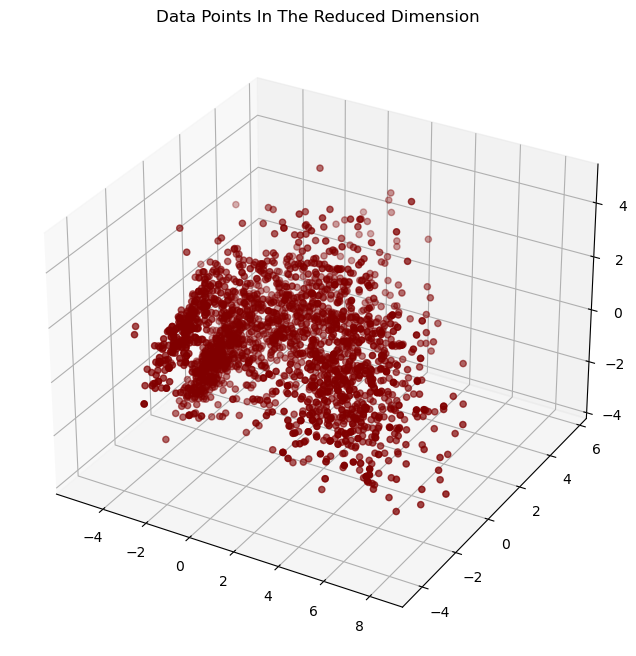

In [353]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_reduced["PC1"],df_reduced["PC2"],df_reduced["PC3"], c="maroon", marker="o" )
ax.set_title("Data Points In The Reduced Dimension")
plt.show()

# III. Gom cụm dữ liệu - Clustering

### 1. Lựa chọn số cụm

Đầu tiên, ta sẽ so sánh hiệu suất của các giá trị k khác nhau (số lượng cụm)

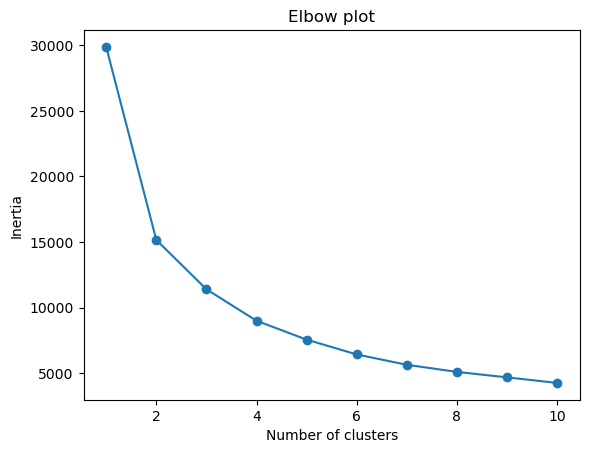

In [354]:
scores = []
for k in range(10):
    kmeans = KMeans(n_clusters=k+1, random_state=42, n_init=10)
    kmeans.fit(df_reduced)
    scores.append(kmeans.inertia_)

plt.plot(range(1, 11), scores, marker='o');
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot');

Để KMeans hoạt động hiệu quả thì khoảng cách từ các điểm dữ liệu đến tâm cụm chứa nó phải là gần nhất. 

Dựa vào biểu đồ, ta có thể thấy điểm khuỷu tay phù hợp là k = 4

### 2. Thực hiện gom cụm dữ liệu

In [355]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(df_reduced)

KMeans(n_clusters=4, n_init=10, random_state=42)

Gán cụm tương ứng của mỗi điểm dữ liệu vào `df`

In [356]:
df['Cluster'] = kmeans.labels_
df_cp['Cluster'] = kmeans.labels_
df_cp['Cluster'].value_counts()

2    724
1    549
3    547
0    416
Name: Cluster, dtype: int64

**Trực quan hoá theo 2D và 3D**

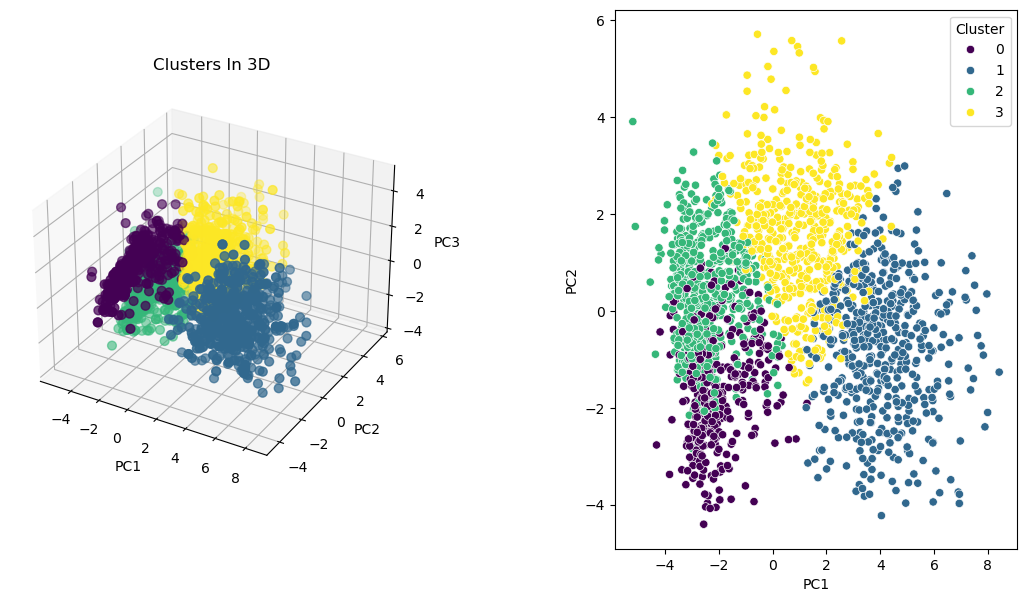

In [357]:
fig = plt.figure(figsize=(13, 7))

# Create a 3D scatter plot in the first subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df_reduced['PC1'], df_reduced['PC2'],df_reduced['PC3'], s=40, c=df["Cluster"], marker='o', cmap="viridis") 
ax1.set_title("Clusters In 3D")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# Create a 2D scatter plot in the second subplot
ax2 = fig.add_subplot(122)
sns.scatterplot(data=df_reduced, x='PC1',y='PC2', hue=df['Cluster'], palette='viridis', ax=ax2)
plt.subplots_adjust(wspace=0.5)
plt.show()


**Nhận xét**

- Dữ liệu được phân ra thành 4 cụm khá rõ ràng

- Riêng cụm 0 và cụm 2 có phần giao nhau tương đối nhiều



# IV. Phân tích theo cụm

## 1. So sánh số lượng khách hàng của các cụm

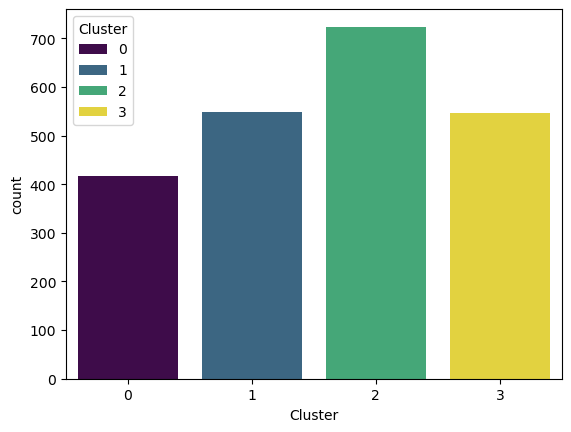

In [358]:
sns.countplot(data=df, x='Cluster', hue='Cluster', palette='viridis');

- Khách hàng thuộc cụm 0 có số lượng đông nhất

- Khách hàng thuộc cụm 1 và 3 có số lượng khá tương đồng với nhau

- Khách hàng thuộc cụm 2 có số lượng là ít nhất


## 2. Phân tích về tuổi tác

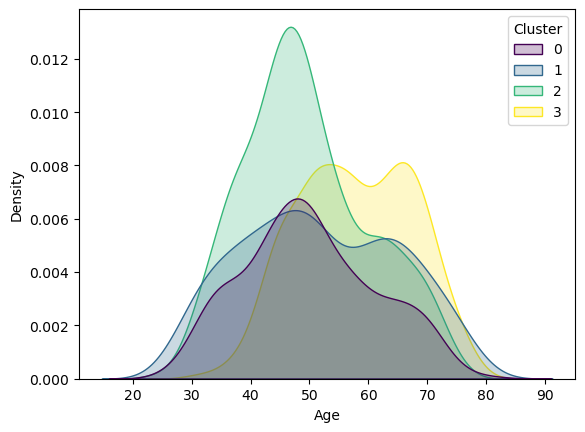

In [359]:
sns.kdeplot(data=df, x='Age', hue='Cluster', fill=True, palette='viridis');

**Một vài đặc trưng về tuổi của các cụm**

- Cụm 0:
    - có số lượng đông đảo nhất
    - độ tuổi tập trung nhiều nhất trong khoảng 40-50
    - nhìn chung, có nhiều người trẻ tuổi nhất

- Cụm 1
    - có số lượng khá tương đông với cụm 2
    - độ tuổi phổ biến là 40-50 tuổi

- Cụm 2
    - độ tuổi phổ biến nằm ở hai khoảng: 40-50 và 60-70

- Cụm 3
    - độ tuổi phổ biến là 50-60 và 65-75
    - là nhóm có số lượng người cao tuổi nhiều nhất, nhìn chung già hơn 3 cụm còn lại

## 3. Phân tích về thu nhập và chi tiêu

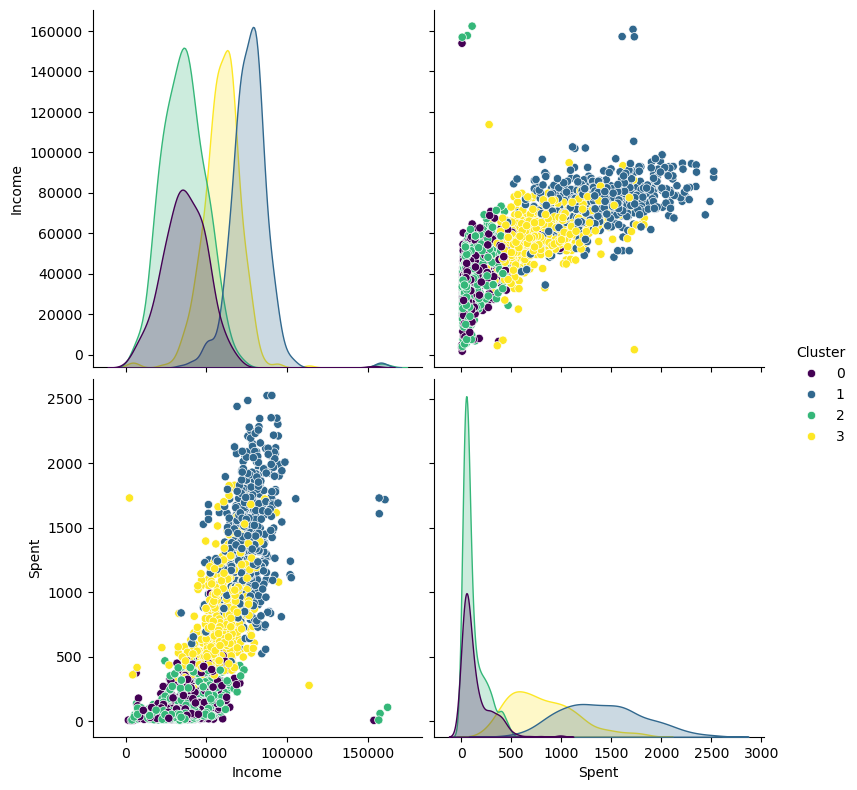

In [360]:

sns.pairplot(data=df[['Income', 'Spent', 'Cluster']], hue='Cluster', palette='viridis', height=4);
plt.show()

Ta dễ thấy rằng

- Cụm 0 và Cụm 2: có thu nhập thấp và chi tiêu thấp

- Cụm 1: là những người có thu nhập cao nhất, chi tiêu cũng nhiều nhất

- Cụm 3: có thu nhập trung bình và chi tiêu cũng ở mức trung bình

In [361]:
df['Total Promotion Accepted'] = df[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1)

## 4. Phân tích về số lượt chấp nhận offer trong các chương trình promotion

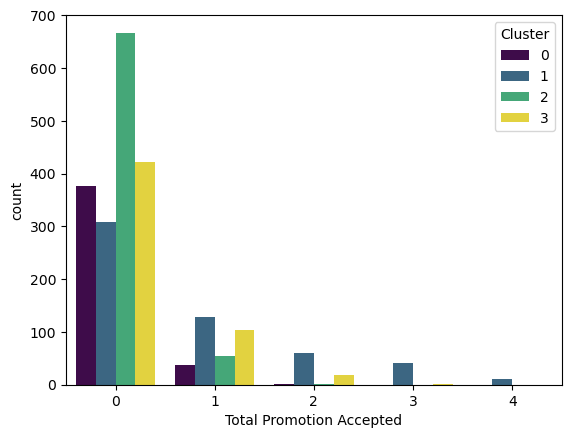

In [362]:
sns.countplot(df, x='Total Promotion Accepted', hue='Cluster', palette='viridis');

- Số lượng người chấp nhận offer trong các promotions còn tương đối thấp

- Cụm 1 có tỉ lệ chấp nhận offer nhiều nhất. Điều này khá dễ hiểu vì họ có thu nhập cao và chi tiêu nhiều, dẫn đến các offer dễ được họ đón nhận hơn

## 5. Phân tích về con cái

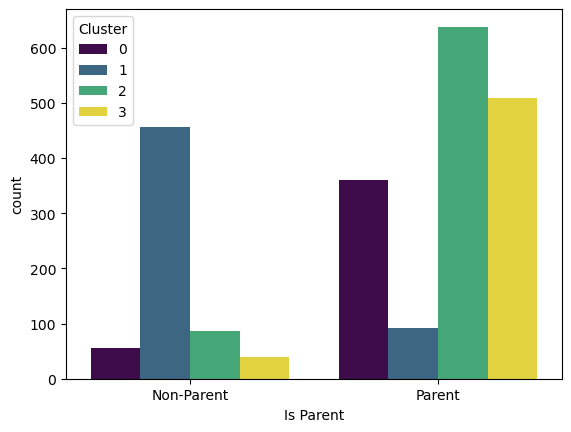

In [363]:
df['Is Parent'] = df['Kids'].apply(lambda x: "Parent" if x > 0 else "Non-Parent")
sns.countplot(df, x='Is Parent', hue='Cluster', palette='viridis');

Rõ ràng ta thấy rằng:

- Cụm 1 chủ yếu là những người chưa con có con

- Các cụm còn lại đều có con

## 7. Phân tích về học vấn

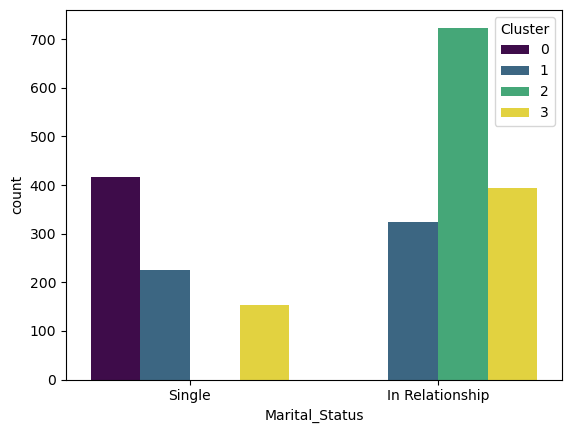

In [364]:
sns.countplot(df, x='Marital_Status', hue='Cluster', palette='viridis');

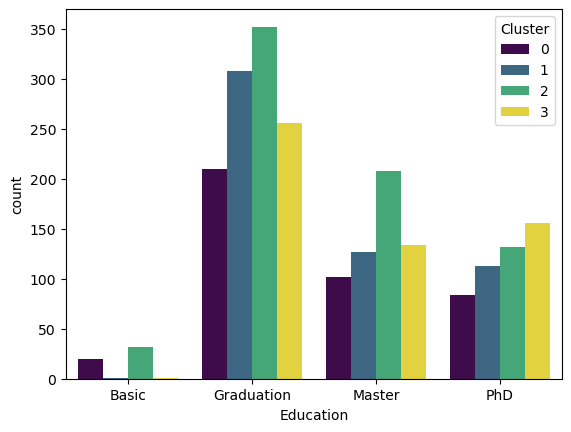

In [365]:
sns.countplot(df.sort_values('Education'), x='Education', hue='Cluster', palette='viridis');

- Đa số các cụm đều có học vấn từ Cử nhân trở lên

- Cụm 0: lan ra ở các loại học vấn, ít nhất là phổ thông và giảm dần từ Củ nhân -> Tiến sĩ

- Cụm 1: không có học vấn phổ thông, giảm dần từ Cử nhân -> Tiến sĩ

- Cụm 2: Tương tự cụm 0

- Cụm 3: không có học vấn phổ thông, nhiều nhất là Cử nhân, kế đến là Tiến sĩ. Nhóm này có học vấn cao nhất


### Kết luận

| Thuộc tính | Cụm 0 |  Cụm 1 |  Cụm 2 |  Cụm 3 |
|------------|--------|--------|--------|--------|
| Số lượng   | Rất nhiều | Nhiều | Trung bình | Nhiều |
| Tuổi tác   | Trung niên | Trung niên | Trung niên | Già|
| Thu nhập   | Thấp | Cao | Thấp | Trung bình |
| Chi tiêu   | Thấp | Cao | Thấp | Trung bình |
| Chấp nhận offer | Không | Ít | Không | Không |
| Có con     | Có | Không | Có | Có |


- Cụm 0: do thu nhập thấp cùng với việc có con nên dẫn đến khó rất hạn chế trong việc chi tiêu và không chấp nhận các offer trong các chương trình promotions của chúng ta

- Cụm 1: thu nhập cao (có thể do trong độ tuổi trung niên nên còn kiếm tiền được) cùng với việc không có con nên tiền làm ra đa số phục vụ cho nhu cầu bản thân dẫn đến chi tiêu nhiều. Có khả năng cao nhất chấp nhận các offers

- Cụm 2: khá tương tự với cụm 0

- Cụm 3: 